<h1>Introduction<h1>

This notebook will summarize the majority of the exploratory data analysis and visualization of different features from the LUCAS cell-free DNA. These are some of the steps that I will take to guarantee that there is a thorough analysis of the data: 
1. Look at the summary statistics of the data
1. Look distribution of variables of interest
1. Find missing data values and fill 


Objective: To make a model to predict survival from other features using ML and estimate feature importance. Survival data is censored, i.e. those alive may continue to live beyond the days listed here.

- Identify feature importance for delfi, stage, and treatment
- Identify feature importance for interaction between delfi, stage, and treatment
- Cross validate
- Approach can be RF or LM, or anything else.


# Setup and Imports

In [60]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl 
import lifelines

First row of excel file is irrelevant title information. Second row represents the actual columns of the data of which are: 
- Patient ID: Patient identifier 
- Survival status: did the patient live or die. 1 = died, 0 = still living
- Days alive: number of days until the patient died or if Survival status = 0 then they've been alive for days alive 
- Histology: the type of cancer that the patient has 
- Stage: the stage of cancer 
- 1st line Oncological treatment: the first procedure that the patient received (best first choice)
- DELFI Score: the cross-validated DELFI score calculated from DELFI methodology of cell-free DNA analysis
- DELFI status: ignore

In [45]:
data = pd.read_excel('data_Lucas_cfDNA_Alan.xlsx', header = 1)
data.head()

,Patient ID,Survival status,Days alive,Histology,Stage,1st line Oncological treatment,DELFI score,DELFI status
0,CGPLLU397P,1,1059,SCLC,I,Surgery,0.099037,0
1,CGPLLU607P,1,1640,Adenocarcinoma,I,Surgery,0.533453,1
2,CGPLLU637P,1,101,Squamous,IV,Palliative Chemotherapy/Radiation,0.822662,1
3,CGPLLU538P,1,1228,Adenocarcinoma,IV,Palliative Chemotherapy/Radiation,0.238950,0
4,CGPLLU349P,1,754,Adenocarcinoma,III,Chemotherapy/Radiation with curative intent,0.199820,0


In [46]:
data.drop(['DELFI status'], axis = 1, inplace = True)
data

,Patient ID,Survival status,Days alive,Histology,Stage,1st line Oncological treatment,DELFI score
0,CGPLLU397P,1,1059,SCLC,I,Surgery,0.099037
1,CGPLLU607P,1,1640,Adenocarcinoma,I,Surgery,0.533453
2,CGPLLU637P,1,101,Squamous,IV,Palliative Chemotherapy/Radiation,0.822662
3,CGPLLU538P,1,1228,Adenocarcinoma,IV,Palliative Chemotherapy/Radiation,0.238950
4,CGPLLU349P,1,754,Adenocarcinoma,III,Chemotherapy/Radiation with curative intent,0.199820
...,...,...,...,...,...,...,...
90,CGPLLU501P,1,1504,Adenocarcinoma,IV,Palliative Chemotherapy/Radiation,1.000000
91,CGPLLU313P,1,28,Adenocarcinoma,IV,Palliative Chemotherapy/Radiation,1.000000
92,CGPLLU404P,1,299,SCLC,IV,Palliative Chemotherapy/Radiation,1.000000
93,CGPLLU321P,1,606,Squamous,III,Palliative Chemotherapy/Radiation,0.265000


Change the data column names, rename treatment

In [47]:
data.columns = [col.lower().replace(' ', '_') for col in data.columns]
data = data.rename(columns={'1st_line_oncological_treatment': 'treatment'})

In [48]:
#one hot encode relevant variables 
data_encoded = pd.get_dummies(data, columns=['stage', 'treatment'], dtype = int)
data_encoded.head()

,patient_id,survival_status,days_alive,histology,delfi_score,stage_I,stage_II,stage_III,stage_IV,treatment_Chemotherapy/Radiation with curative intent,treatment_No treatment,treatment_Palliative Chemotherapy/Radiation,treatment_Surgery,treatment_Surgery+adjuvant treatment
0,CGPLLU397P,1,1059,SCLC,0.099037,1,0,0,0,0,0,0,1,0
1,CGPLLU607P,1,1640,Adenocarcinoma,0.533453,1,0,0,0,0,0,0,1,0
2,CGPLLU637P,1,101,Squamous,0.822662,0,0,0,1,0,0,1,0,0
3,CGPLLU538P,1,1228,Adenocarcinoma,0.238950,0,0,0,1,0,0,1,0,0
4,CGPLLU349P,1,754,Adenocarcinoma,0.199820,0,0,1,0,1,0,0,0,0


In [49]:
file_name = 'data_Lucas.csv'
data.to_csv(file_name)

# Exploratory Data Analysis

This section will explore the properties of the dataset, including the fact that it is right-censored, due to some patients surviving longer than the study time.

In [50]:
data.head()

,patient_id,survival_status,days_alive,histology,stage,treatment,delfi_score
0,CGPLLU397P,1,1059,SCLC,I,Surgery,0.099037
1,CGPLLU607P,1,1640,Adenocarcinoma,I,Surgery,0.533453
2,CGPLLU637P,1,101,Squamous,IV,Palliative Chemotherapy/Radiation,0.822662
3,CGPLLU538P,1,1228,Adenocarcinoma,IV,Palliative Chemotherapy/Radiation,0.238950
4,CGPLLU349P,1,754,Adenocarcinoma,III,Chemotherapy/Radiation with curative intent,0.199820


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       95 non-null     object 
 1   survival_status  95 non-null     int64  
 2   days_alive       95 non-null     int64  
 3   histology        95 non-null     object 
 4   stage            95 non-null     object 
 5   treatment        95 non-null     object 
 6   delfi_score      95 non-null     float64
dtypes: float64(1), int64(2), object(4)
memory usage: 5.3+ KB


In [52]:
data.describe()

,survival_status,days_alive,delfi_score
count,95.000000,95.000000,95.000000
mean,0.821053,851.326316,0.711420
std,0.385342,986.064102,0.316914
min,0.000000,11.000000,0.029739
25%,1.000000,89.500000,0.481004
50%,1.000000,364.000000,0.799066
75%,1.000000,1354.500000,0.999982
max,1.000000,2774.000000,1.000000


Find any missing data

In [53]:
data.isnull().sum()

patient_id         0
survival_status    0
days_alive         0
histology          0
stage              0
treatment          0
delfi_score        0
dtype: int64

No null data points, we do not need to impute any new values

### Days Alive Exploration

First explore the days_alive variable, our target variable

In [54]:
data['days_alive'].describe()

count      95.000000
mean      851.326316
std       986.064102
min        11.000000
25%        89.500000
50%       364.000000
75%      1354.500000
max      2774.000000
Name: days_alive, dtype: float64

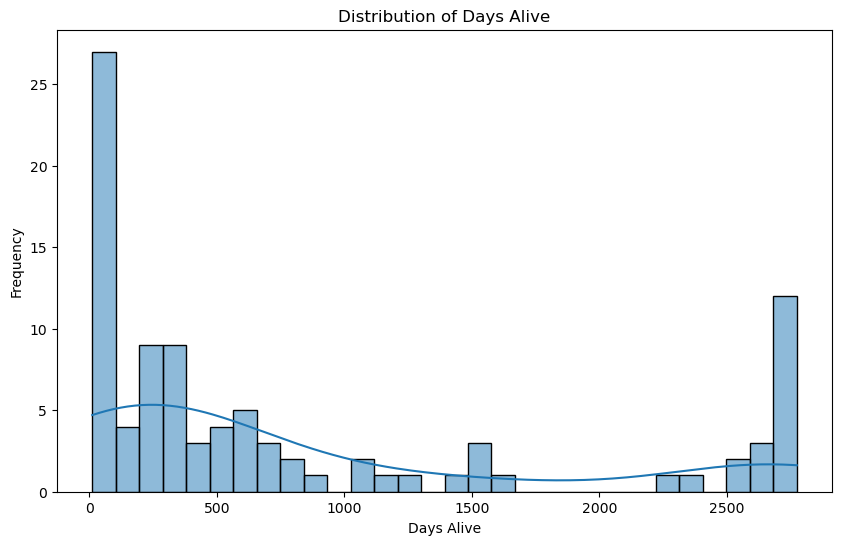

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(data['days_alive'], kde=True, bins = 30)
plt.title("Distribution of Days Alive")
plt.xlabel("Days Alive")
plt.ylabel("Frequency")
plt.show()


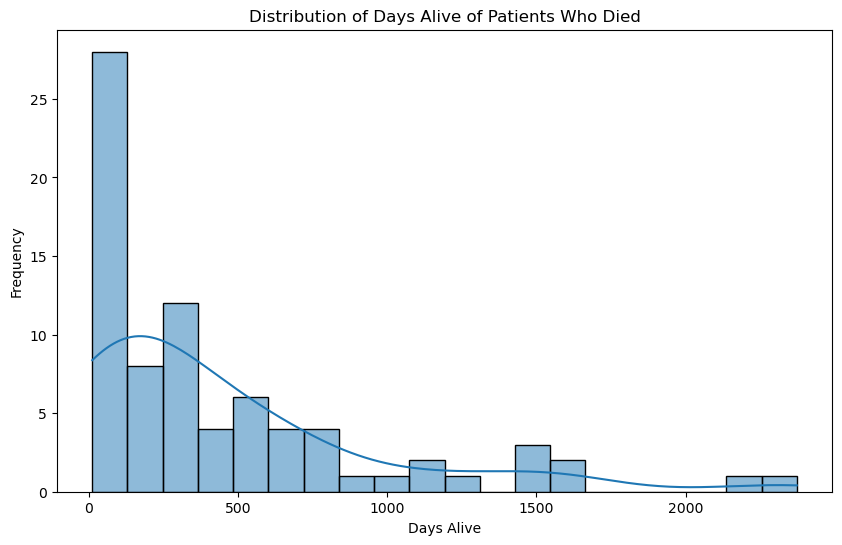

In [25]:
dead_patients = data[data['survival_status'] == 1]
plt.figure(figsize=(10,6))
sns.histplot(dead_patients['days_alive'], kde=True, bins = 20)
plt.title("Distribution of Days Alive of Patients Who Died")
plt.xlabel("Days Alive")
plt.ylabel("Frequency")
plt.show()


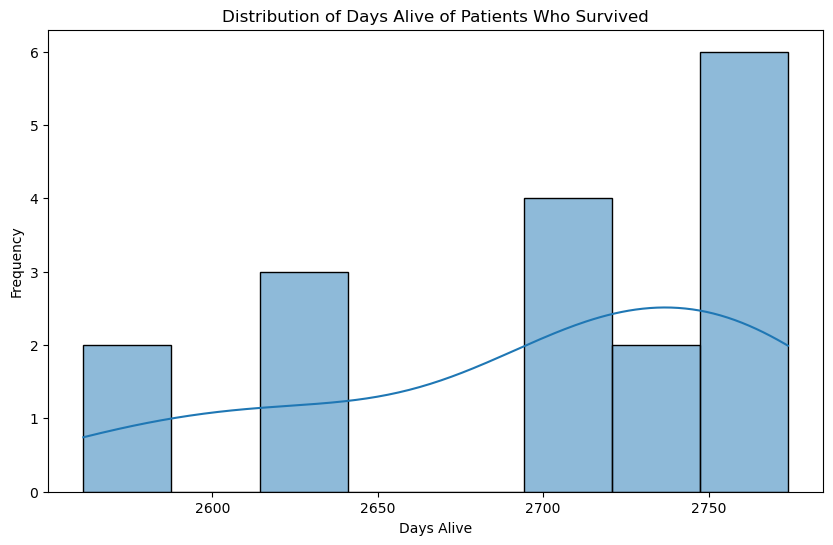

In [30]:
live_patients = data[data['survival_status'] == 0]
plt.figure(figsize=(10,6))
sns.histplot(live_patients['days_alive'], kde=True, bins = 8)
plt.title("Distribution of Days Alive of Patients Who Survived")
plt.xlabel("Days Alive")
plt.ylabel("Frequency")
plt.show()


Patients who died has a distribution of days alive that is severely right skew <br>
Patients who survived have a slight left skew, but no measureable trend due to lack of samples

Now we want to see the distribution of patients who survived and those that didn't with respect to days alive

In [13]:
death_count = data['survival_status'].sum()
survive_count = len(data)-death_count

print(f"Number of patients that died: {death_count}")
print(f"Number of patients that survived: {survive_count}")

Number of patients that died: 78
Number of patients that survived: 17


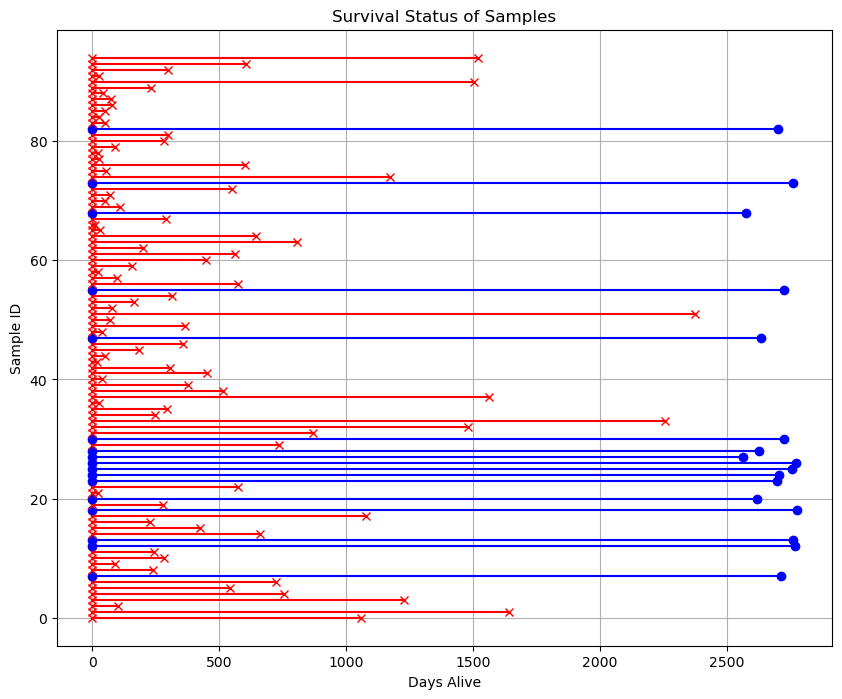

In [14]:
data['sample_id'] = range(1, len(data)+1)

plt.figure(figsize=(10,8))

for index, row in data.iterrows():
    if row['survival_status'] == 1:
        # Mark with 'x' if the sample died
        plt.plot([0, row['days_alive']], [index, index], 'r-', marker='x')
    else:
        # Mark with 'o' if the sample did not die
        plt.plot([0, row['days_alive']], [index, index], 'b-', marker='o')


plt.xlabel('Days Alive')
plt.ylabel('Sample ID')
plt.title('Survival Status of Samples')
plt.grid(True)
plt.show()

The patients that had survival_status = 0, or were alive also had different survival times. This means that the experiment tracked these individuals for different times. 

### DELFI Exploration

Now explore each individual variable: delfi_score, stage, treatment

In [76]:
data['delfi_score'].describe()

count    95.000000
mean      0.711420
std       0.316914
min       0.029739
25%       0.481004
50%       0.799066
75%       0.999982
max       1.000000
Name: delfi_score, dtype: float64

We know from the paper that those with lung cancer were more predisposed to higher delfi scores. We can plot the delfi score on a boxplot and then stratified by the different treatments and stages

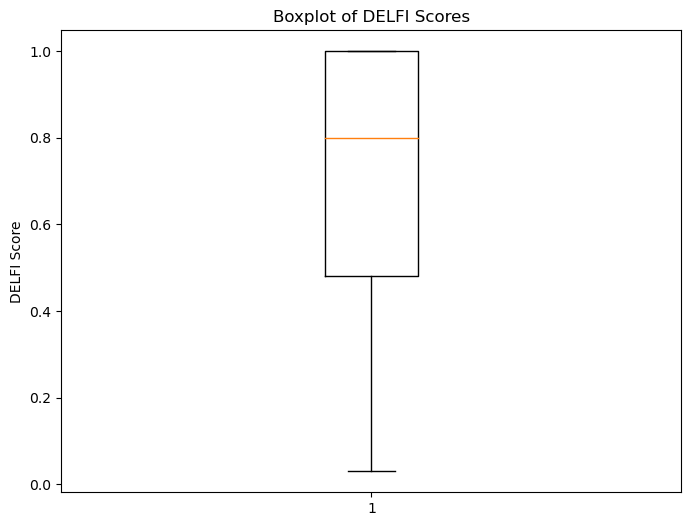

In [77]:
plt.figure(figsize=(8,6))
plt.boxplot(data['delfi_score'])
plt.title("Boxplot of DELFI Scores")
plt.ylabel("DELFI Score")
plt.show()

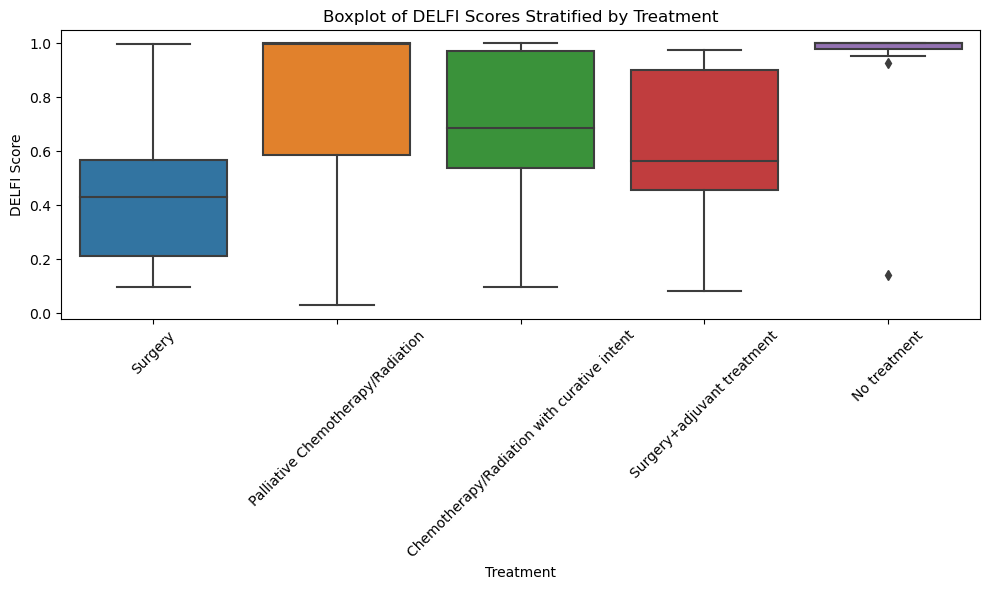

In [78]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='1st_line_oncological_treatment', y='delfi_score', data=data)
plt.title('Boxplot of DELFI Scores Stratified by Treatment')
plt.xlabel('Treatment')
plt.ylabel('DELFI Score')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to fit the labels
plt.show()


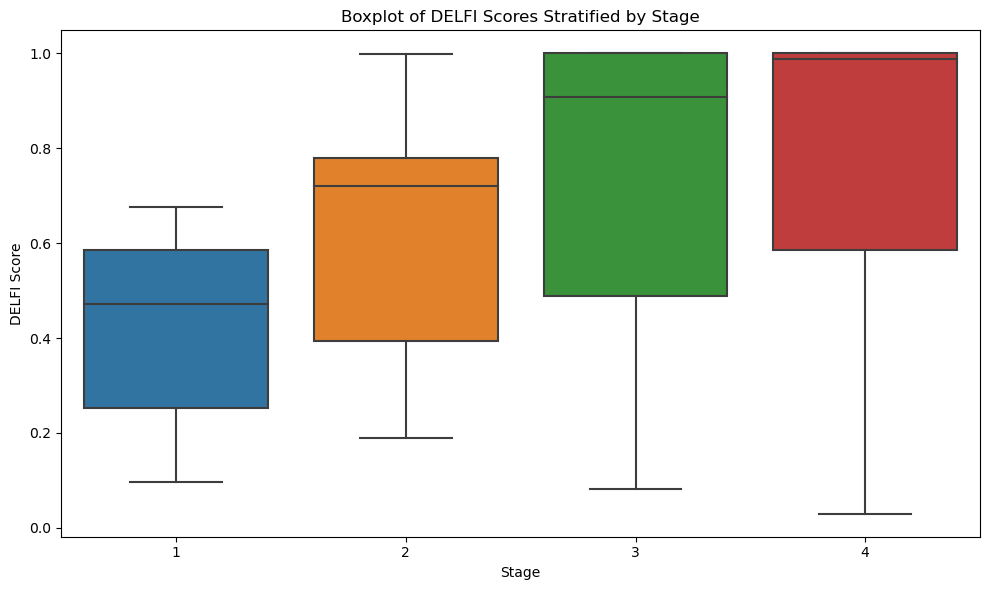

In [79]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='stage_encoded', y='delfi_score', data=data)
plt.title('Boxplot of DELFI Scores Stratified by Stage')
plt.xlabel('Stage')
plt.ylabel('DELFI Score')
plt.tight_layout()  # Adjust the layout to fit the labels
plt.show()

### Stage Exploration

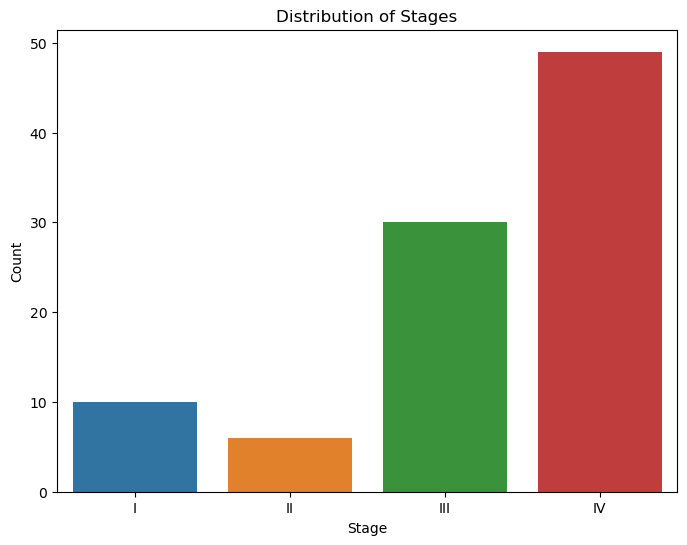

In [80]:
plt.figure(figsize=(8,6))
sns.countplot(x = 'stage', data = data, order = ['I', 'II', 'III', 'IV'])
plt.title("Distribution of Stages")
plt.xlabel("Stage")
plt.ylabel('Count')
plt.show()

It seems that most people have stage IV cancer in this distribution, which may mean that we have higher numbers of those with higher delfi scores

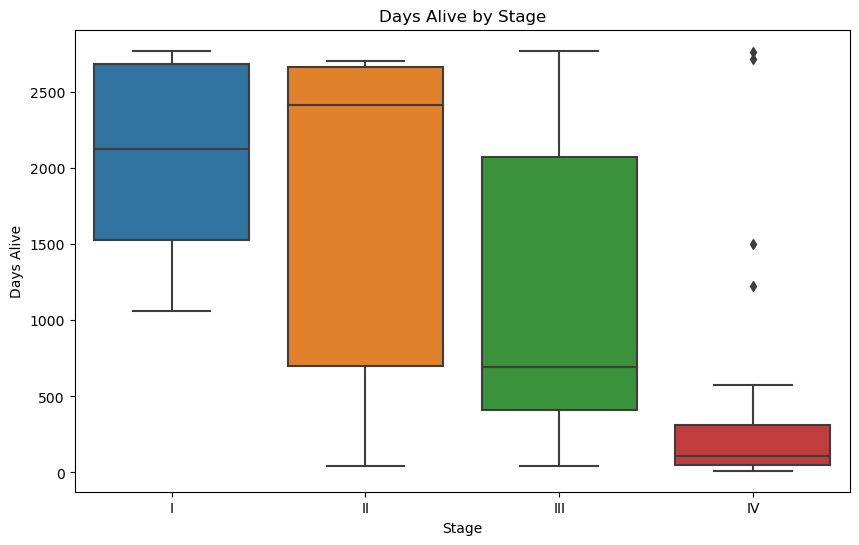

In [66]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='stage', y='days_alive', data=data, order=['I', 'II', 'III', 'IV'])
plt.title('Days Alive by Stage')
plt.xlabel('Stage')
plt.ylabel('Days Alive')
plt.show()

As expected, patients with more severe stage of cancer generally survived shorter periods than those that had less severe stage

The patients with more severe stages of cancer generally have a larger DELFI score. 

### Treatment Exploration

In [31]:
data['1st_line_oncological_treatment'].value_counts()

1st_line_oncological_treatment
Palliative Chemotherapy/Radiation              43
Chemotherapy/Radiation with curative intent    20
Surgery                                        15
No treatment                                   12
Surgery+adjuvant treatment                      5
Name: count, dtype: int64

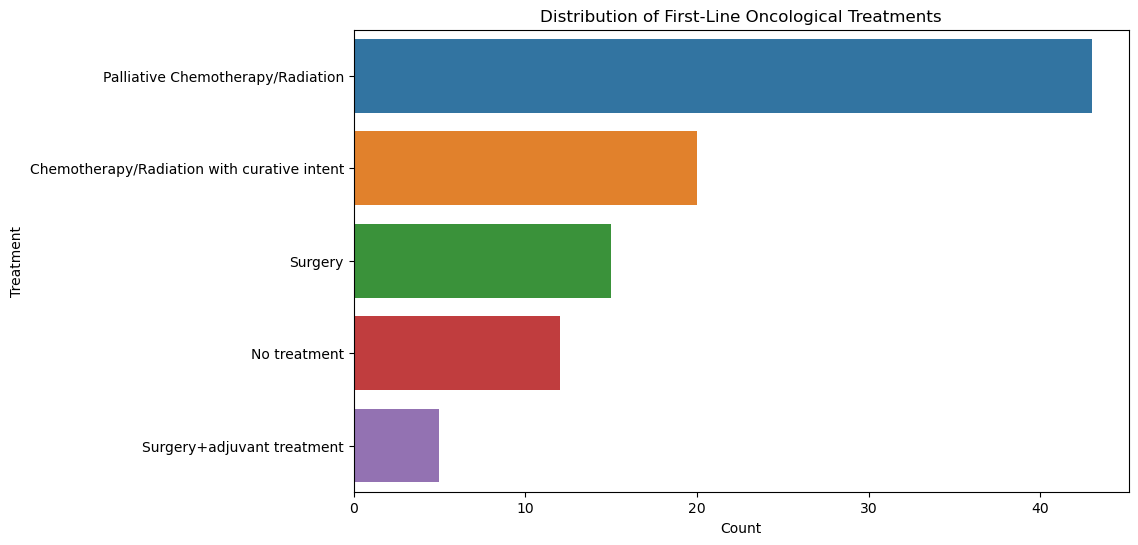

In [32]:
plt.figure(figsize=(10, 6))
sns.countplot(y='1st_line_oncological_treatment', data=data, order = data['1st_line_oncological_treatment'].value_counts().index)
plt.title('Distribution of First-Line Oncological Treatments')
plt.xlabel('Count')
plt.ylabel('Treatment')
plt.show()


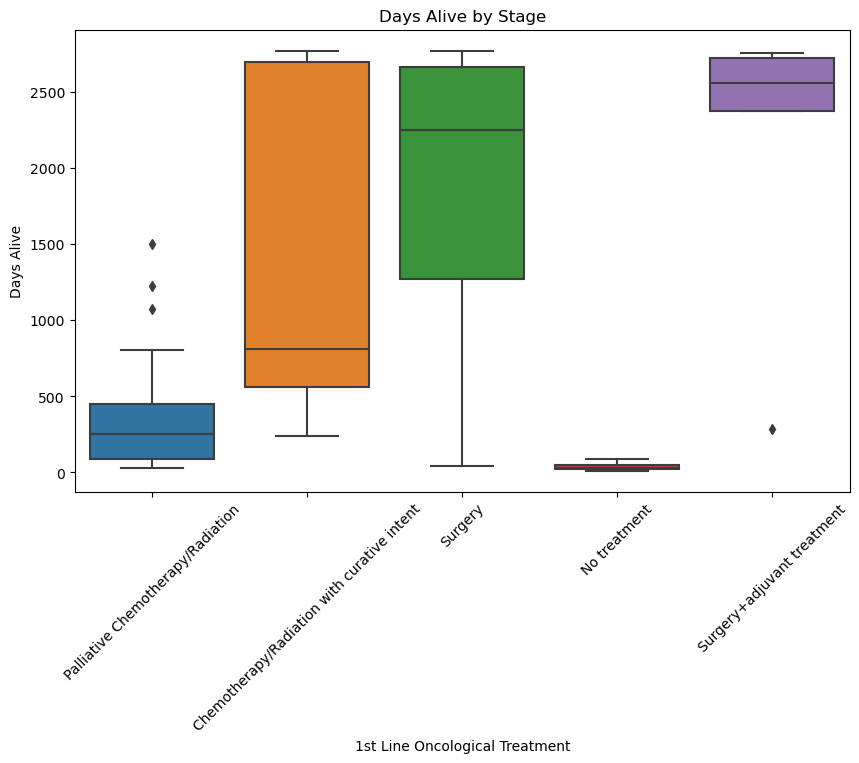

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment', y='days_alive', data=data, order=data['treatment'].value_counts().index)
plt.title('Days Alive by Stage')
plt.xlabel('1st Line Oncological Treatment')
plt.xticks(rotation=45)
plt.ylabel('Days Alive')
plt.show()

There does not really seem to be a trend in which the first line oncological treatment seems to impact days alive. Some treatments such as no treatment have almost no data, which means we cannot make an accurate assumption on the trend. However, it does seemt hat palliative chemotherapy has the worst survival, but this could be due to the context of palliative chemotherapy. Some of these treatments may be given in more severe scenarios, so in turn it could be more related to the stage of cancer.

# Survival Analysis

We want to do some exploratory data analysis on the survival of the patients, or plot the survival curves based on the different variables so we can measure correlation on days alive

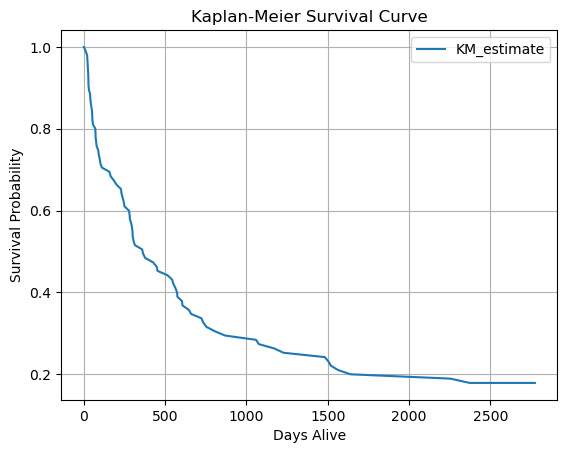

In [63]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter() 

kmf.fit(data['days_alive'], event_observed=data['survival_status'])

kmf.survival_function_.plot()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Days Alive')
plt.ylabel('Survival Probability')
plt.grid()
plt.show()

## Kaplan Meier Curves

We want to use Kaplan Meier curves to estimate preliminary relationships between the survival status and days alive and the variables of interest: stage, treatment, and delfi score.

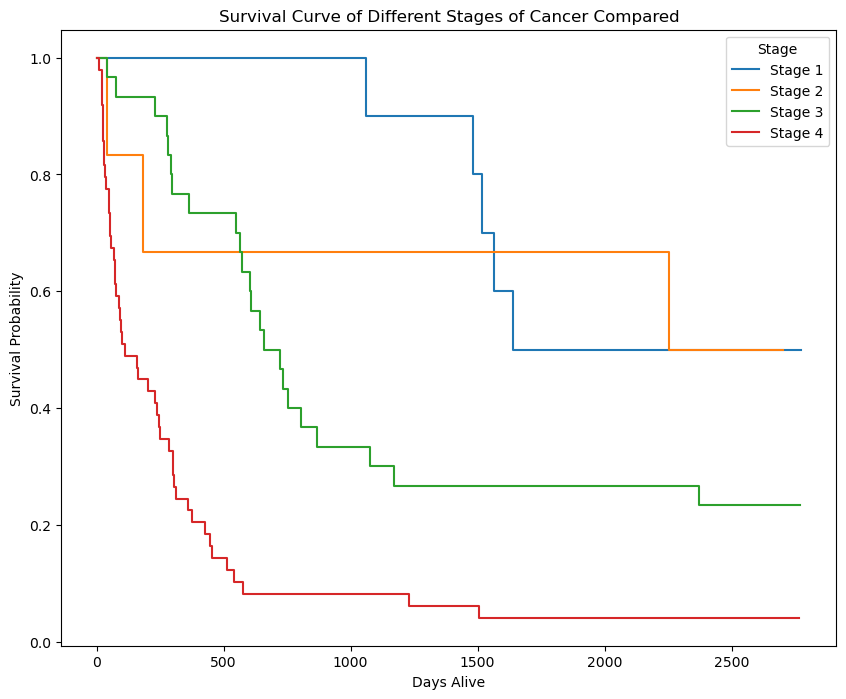

In [70]:
#stage curves
data_stage1 = data[data['stage'] == 'I']
data_stage2 = data[data['stage'] == 'II']
data_stage3 = data[data['stage'] == 'III']
data_stage4 = data[data['stage'] == 'IV']

kmf = KaplanMeierFitter()

data_stages = [data_stage1, data_stage2, data_stage3, data_stage4]

plt.figure(figsize = (10,8))

for i, stage_data in enumerate(data_stages, start = 1): 
    kmf.fit(stage_data['days_alive'], stage_data['survival_status'], label=f'Stage {i}')
    kmf.plot(ci_show = False)

plt.title("Survival Curve of Different Stages of Cancer Compared")
plt.xlabel("Days Alive")
plt.ylabel("Survival Probability")
plt.legend(title = 'Stage')
plt.show()




Through just the kaplan meier test, it is pretty evident that there are spearate curves for at least stages 1,2, and 4 of cancer. Although stage 2 overlaps with both stage 1 and stage 3, arguably it has a different curve profile

In [74]:
data['treatment'].value_counts()

treatment
Palliative Chemotherapy/Radiation              43
Chemotherapy/Radiation with curative intent    20
Surgery                                        15
No treatment                                   12
Surgery+adjuvant treatment                      5
Name: count, dtype: int64

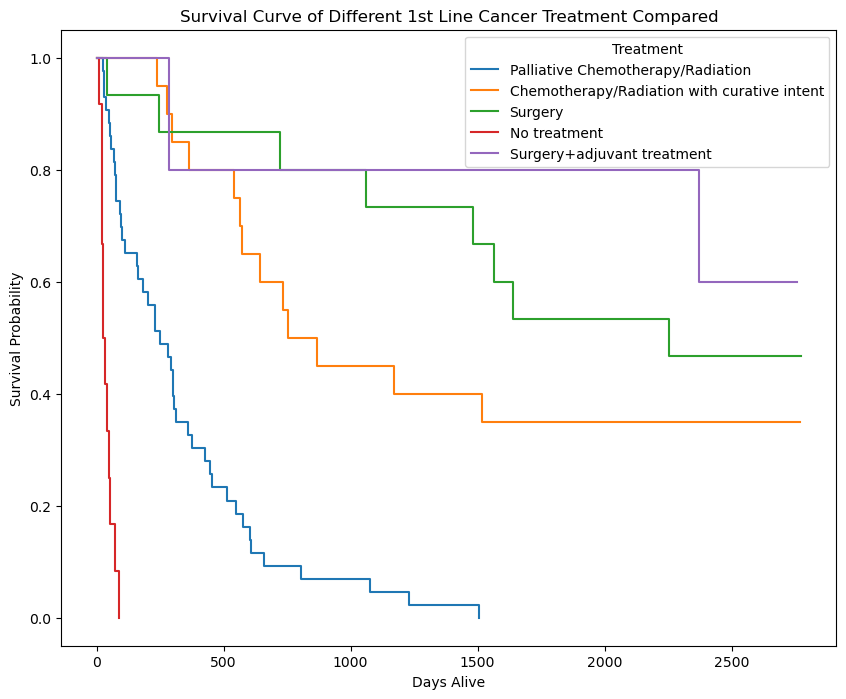

In [75]:
data_pcr = data[data['treatment'] == 'Palliative Chemotherapy/Radiation']
data_chemo = data[data['treatment'] == 'Chemotherapy/Radiation with curative intent']
data_surg = data[data['treatment'] == 'Surgery']
data_no = data[data['treatment'] == 'No treatment']
data_surgadj = data[data['treatment'] == 'Surgery+adjuvant treatment']

kmf = KaplanMeierFitter()

data_treatments = {"Palliative Chemotherapy/Radiation":data_pcr, 
                   'Chemotherapy/Radiation with curative intent':data_chemo, 
                   'Surgery':data_surg, 
                  'No treatment':data_no, 
                  'Surgery+adjuvant treatment':data_surgadj}

plt.figure(figsize = (10,8))

for treatment in data_treatments.keys(): 
    curr_data = data_treatments.get(treatment)
    kmf.fit(curr_data['days_alive'], curr_data['survival_status'], label= treatment)
    kmf.plot(ci_show = False)

plt.title("Survival Curve of Different 1st Line Cancer Treatment Compared")
plt.xlabel("Days Alive")
plt.ylabel("Survival Probability")
plt.legend(title = 'Treatment')
plt.show()


The treatment curve seems to have differing curves, meaning there is a good sign that treatment is also significant in predicting days alive.

## Log-Rank Tests

Now that we've plotted the survival relationships we want to test with a significance test if the categorical variables are actually significant in prediction.

In [77]:
from lifelines.statistics import multivariate_logrank_test

stage_result = multivariate_logrank_test(event_durations= data['days_alive'], groups= data['stage'], event_observed= data['survival_status'])
treatment_result = multivariate_logrank_test(event_durations= data['days_alive'], groups= data['treatment'], event_observed= data['survival_status'])

print(stage_result)
print(f"P-value for stage: {stage_result.p_value}")
print()
print()
print(treatment_result)
print(f"P-value for treatment result: {treatment_result.p_value}")

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          42.95 <0.005     28.56
P-value for stage: 2.5260066060537066e-09


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         128.48 <0.005     86.65
P-value for treatment result: 8.221556846731129e-27


Both p-value are significantly less than 0.005, meaning we can conclude that the stage and treatment variables are significant in relationship with days alive and survival status.

## Cox Proportional Hazard Tests

Procedure: we will utilize the Cox Proportional Hazards Test to determine if the models developed with our features of significance are significant. 
1. We will start with individual cox PH models with only one variable at a time, then determining hazard ratio from it.
1. Then we will fit multivariable cox PH models with combinations/subsets of features and full model with all features

In [ ]:
from lifelines import CoxPHFitter


## Is there any trouble of Interaction or Multicollinearity? 